# Jupyter Notebook for 0-6977
The scripts below illustrate using results of PeakFQ to estimate aribtiary quantiles, for LP3 distribution model.  These are intended for pedagogical (training) purposes.

## The LP3 model

The Pearson Type 3 data model can be expressed using the Gamma Cumulative Density function as:

$$ F(X) = 1.0 - \int_{-\infty}^{X}{\frac{(\frac{x-\tau}{\beta})^{\alpha - 1} exp(-(\frac{x-\tau}{\beta}))}{|\beta|\Gamma(\alpha)} dx} $$

where $F(X)$ is the quantile (exceedence probability) associated with the value $X$, and 

- $\alpha = \frac{4}{\gamma}$
- $\beta = sign(\gamma)\sqrt{\frac{\sigma^2}{\alpha}}$
- $\tau = \mu - \alpha \beta$

the values of $\mu$,$\sigma$,$\gamma$ are sourced from the PeakFQ output as the mean, standard deviation, and skew, respectively as depicted in the figure below:

![](PeakFQ.png)

The remainder of this notebook, uses the quantile function above to estimate discharge values $X$ associated with arbitrary exceedence probabilities $F(X)$

The first script block below: 

- Resets the notebook (clears the workspace)
- Imports necessary packages (these should be available with ordinary Anaconda install)
- Defines a few auxiliary functions

In [2]:
%reset -f
import pandas
import scipy.stats # import scipy stats package
import math        # import math package
import numpy       # import numpy package
import matplotlib.pyplot # the python plotting library
# log and antilog
def loggit(x):  # A prototype function to log10 transform x
    return(math.log10(x))
def antiloggit(x):  # A prototype function to inverse transform log10 x
    return(10**(x))
# plotting position functions
def weibull_pp(sample): # plotting position function
# returns a list of plotting positions; sample must be a numeric list
    weibull_pp = [] # null list to return after fill
    sample.sort(reverse=True) # sort the sample list in place
    for i in range(0,len(sample),1):
        weibull_pp.append((i+1)/(len(sample)+1))
    return weibull_pp
# LP3-core model
def gammacdf(x,tau,alpha,beta): # Gamma Cumulative Density function - with three parameter to one parameter convert
    xhat = x-tau
    lamda = 1.0/beta
    gammacdf = scipy.stats.gamma.cdf(lamda*xhat, alpha)
    return gammacdf

The script block below reads in the observations; it is not necessary but is included to make a graphic later. The graphic is useful to make initial guesses for the quantile finder.

In [3]:
observations = pandas.read_csv('guadelupe.txt')  #Reading a .csv file
#observations.head() #examine structure just read
sample = observations['Peak'].apply(loggit).tolist() # put the log peaks into a list
plotting = weibull_pp(sample)

This block uses values from PeakFQ to parameterize a LP3 distribution model, then build a set of values for plotting.

In [4]:
# all in log space
model_mean  = 4.0289
model_stdev = 0.7144
model_skew  = -0.507 # scipy.stats.skew(sample)
model_alpha = 4.0/(model_skew**2)
model_beta  = numpy.sign(model_skew)*math.sqrt(model_stdev**2/model_alpha)
model_tau   = model_mean - model_alpha*model_beta

xmodel = []; ymodelcdf = []
#xlow = (1); xhigh = (12) ; howMany = 100
xlow = (0.9*min(sample)); xhigh = (1.1*max(sample)) ; howMany = 100
xstep = (xhigh - xlow)/howMany
for i in range(0,howMany+1,1):
    xmodel.append(xlow + i*xstep)
    yvalue = 1.0 - gammacdf(xlow + i*xstep,model_tau,model_alpha,model_beta) # exceedence probabilities
    ymodelcdf.append(yvalue) 

The next block builds a plot; blue markers originate from the annual peak file from the NWIS website, the red curve is the LP3 distribution model.

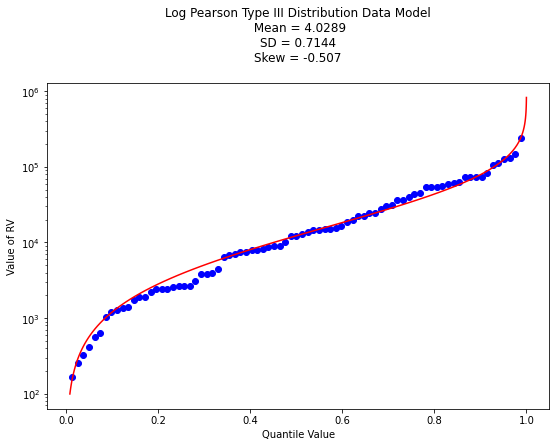

In [25]:
sample.sort() 
# inverse transform the peaks, and the data model peaks
psample = []
for i in range(len(sample)):
    psample.append(antiloggit(sample[i]))
x = [] #null list for plotting
for i in range(len(xmodel)):
    x.append(antiloggit(xmodel[i]))
myfigure = matplotlib.pyplot.figure(figsize = (9,6)) # generate a object from the figure class, set aspect ratio
matplotlib.pyplot.yscale('log')
#matplotlib.pyplot.xscale('log')
matplotlib.pyplot.scatter(plotting, psample ,color ='blue') 
matplotlib.pyplot.plot(ymodelcdf, x, color ='red')
matplotlib.pyplot.xlabel("Quantile Value") 
matplotlib.pyplot.ylabel("Value of RV") 
mytitle = "Log Pearson Type III Distribution Data Model\n "
mytitle += "Mean = " + str((model_mean)) + "\n"
mytitle += "SD = " + str((model_stdev)) + "\n"
mytitle += "Skew = " + str((model_skew)) + "\n"
#mytitle += "Mean = " + str(antiloggit(model_mean)) + "\n"
#mytitle += "SD = " + str(antiloggit(model_stdev)) + "\n"
#mytitle += "Skew = " + str(1-antiloggit(model_skew)) + "\n"
matplotlib.pyplot.title(mytitle) 
matplotlib.pyplot.show()

Ths block below is where arbitrary quantiles can be found, the script uses Newton's method to equate a discharge value with a quantile.  It takes some analyst input to make a good initial guess, hence the plot.

In [30]:
# quantile finder
import math # import math package
import scipy.stats # import scipy stats package
import scipy.optimize # import newton's method 
def loggit(x):  # A prototype function to log10 transform x
    return(math.log10(x))
def gammacdf(x,tau,alpha,beta): # Gamma Cumulative Density function - with three parameter to one parameter convert
    xhat = x-tau
    lamda = 1.0/beta
    gammacdf = scipy.stats.gamma.cdf(lamda*xhat, alpha)
    return gammacdf
def f(x): # A prototype function to find x such that f(x)->0
    global quantile
    argument = loggit(x)
    gammavalue = gammacdf(argument,model_tau,model_alpha,model_beta)
    return gammavalue - quantile
# below all in log space
model_mean  = float(input("Enter Sample/Station Mean")) # example = 4.0289
model_stdev = float(input("Enter Sample/Station Std. Deviation")) # example = 0.7144
model_skew  = float(input("Enter Sample/Station GenSkew"))# example -0.507
# gamma equivalents                    
model_alpha = 4.0/(model_skew**2)
model_beta  = numpy.sign(model_skew)*math.sqrt(model_stdev**2/model_alpha)
model_tau   = model_mean - model_alpha*model_beta
# quantile finder
quantile = float(input("Enter a desired exceedence probability"))
prompt = "Enter a discharge guess, (the mean model value is " + str(round(10**model_mean,2)) + " )"
myguess =  float(input(prompt))
myanswer = scipy.optimize.newton(f, myguess)
print("Estimated discharge at AEP ",round(quantile,3),"is ",round(myanswer,1)," L3/T ")

Enter Sample/Station Mean 4.0289
Enter Sample/Station Std. Deviation 0.7144
Enter Sample/Station GenSkew -0.507
Enter a desired exceedence probability 0.01
Enter a discharge guess, (the mean model value is 10688.09 ) 10200


Estimated discharge at AEP  0.01 is  264013.5  L3/T 


## Readings

1. England, J.F., Jr., Cohn, T.A., Faber, B.A., Stedinger, J.R., Thomas, W.O., Jr., Veilleux, A.G., Kiang, J.E., and Mason, R.R., Jr., 2018, Guidelines for determining flood flow frequency—Bulletin 17C (ver. 1.1, May 2019): U.S. Geological Survey Techniques and Methods, book 4, chap. B5, 148 p., [https://doi.org/10.3133/tm4B5](https://doi.org/10.3133/tm4B5.).
